[View in Colaboratory](https://colab.research.google.com/github/Hoiy/kaggle-tgs-salt-identification-challenge/blob/master/model_keras_unet.ipynb)

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import dotenv
import keras
import os
import gc
import cv2
dotenv.load_dotenv('.env')

!mkdir model
# !gsutil rsync gs://{os.environ['GCP_BUCKET']}/model model

Using TensorFlow backend.


mkdir: cannot create directory ‘model’: File exists


In [2]:
train = pd.read_csv('raw/train.csv').set_index('id')
test = pd.read_csv('raw/sample_submission.csv').set_index('id')
depths = pd.read_csv('raw/depths.csv').set_index('id')

train = pd.merge(train, depths, left_index=True, right_index=True, how='inner')
train.shape, test.shape, depths.shape

((4000, 2), (18000, 1), (22000, 1))

In [0]:
IMG_SIZE = 101

In [4]:
X_train = [cv2.resize(cv2.imread("./raw/images/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(train.index)]
X_train = np.expand_dims(np.array(X_train), -1)
X_train = X_train / 255

y_train = [cv2.resize(cv2.imread("./raw/masks/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(train.index)]
y_train = np.expand_dims(np.array(y_train), -1)
y_train = y_train / 255


X_test = [cv2.resize(cv2.imread("./raw/images/{}.png".format(idx), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) for idx in tqdm(test.index)]
X_test = np.expand_dims(np.array(X_test), -1)
X_test = X_test / 255


X_train.shape, y_train.shape, X_test.shape

100%|██████████| 18000/18000 [00:08<00:00, 2089.95it/s]


((4000, 101, 101, 1), (4000, 101, 101, 1), (18000, 101, 101, 1))

In [0]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb
from matplotlib import pyplot as plt

def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

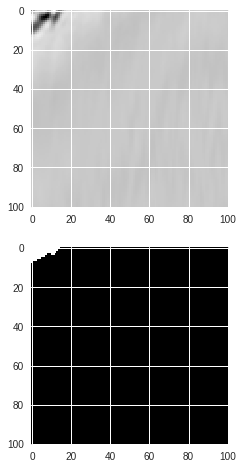

In [6]:
visualize(X_train[2].reshape(IMG_SIZE, IMG_SIZE), y_train[2].reshape(IMG_SIZE, IMG_SIZE))

In [12]:
import keras
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout, BatchNormalization, SpatialDropout2D, UpSampling2D, Activation, Add

from keras import backend as K
import tensorflow as tf


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
  
  

# define iou or jaccard loss function
def jaccard_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    
    epsilon = tf.keras.backend.epsilon()
    
    score = (intersection + epsilon) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + epsilon)
    return 1 - score


# input: (x, 101, 101, 1), (x, 101, 101, 1)
# output: (x,)
def batch_iou(y_true, y_pred):
    pred_ = tf.round(y_pred)
    truth_ = y_true
    
    i = tf.reduce_sum(pred_ * truth_, axis=[1,2,3])
    u = tf.reduce_sum((pred_ + truth_) - (pred_ * truth_), axis=[1,2,3])
    
    epsilon = tf.keras.backend.epsilon()
    return (i + epsilon) / (u + epsilon)

# input: (x,)
# output: ()
def mean_iou(y_true, y_pred):
    ious = batch_iou(y_true, y_pred)
    ious = tf.reshape(ious, (-1,1))
    ious = tf.tile(ious, (1,10))
    thresholds = tf.range(0.5, 1.0, delta=0.05)
    
    return tf.reduce_mean(tf.to_float(ious >= thresholds))

  

def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * jaccard_loss(y_true, y_pred)
  
  
# def mean_iou(y_true, y_pred):
#     return tf.reduce_mean(tf.to_float(tf.greater(tf.round(y_true), y_pred)))
    

# def mean_iou(y_true, y_pred):
#     i = tf.round(y_pred) * tf.round(y_true)
#     o = tf.round(y_pred) * tf.round(y_true)
#     mean_iou = tf.metrics.mean_iou(y_true, tf.round(y_pred), 1)
#     print(mean_iou)
#     print(tf.tile(mean_iou, 10))
#     print(mean_iou[0])
#     return mean_iou[0]
#     return tf.reduce_mean(tf.tile(mean_iou, 10))
  
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)


# def convolution_block(x, filters, size):
#     return x



  
def residual_block(blockInput, filters):
    x = Conv2D(filters, 3, strides=(1,1), padding='same', activation=None)(blockInput)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=(1,1), padding='same', activation=None)(x)
    x = Add()([x, blockInput])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
  
def res_block(i, filters=16):
    n1 = Conv2D(filters, 1, activation='relu', padding='same')(i)
    n3 = Conv2D(filters, 3, activation='relu', padding='same')(i)
    n5 = Conv2D(filters, 5, activation='relu', padding='same')(i)
    n = Concatenate()([n1, n3, n5])
    n = BatchNormalization()(n)
    
    n1 = Conv2D(filters, 1, activation='relu', padding='same')(n)
    n3 = Conv2D(filters, 3, activation='relu', padding='same')(n)
    n5 = Conv2D(filters, 5, activation='relu', padding='same')(n)
    n = Concatenate()([n1, n3, n5])
    n = BatchNormalization()(n)
    
#     n = Conv2D(1, 1, activation='relu', padding='same')(n)
#     n = Concatenate()([i, n])
#     n = BatchNormalization()(n)
    return n

  
# def level_block(inp, dim, depth, inc, acti, do, bn, mp, up, res):
#     if depth > 0:
#         n = conv_block(m, dim, acti, bn, res)
#         m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
#         m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
#         if up:
#             m = UpSampling2D()(m)
#             m = Conv2D(dim, 2, activation=acti, padding='same')(m)
#         else:
# #             padding = ['valid', 'same','same','valid','same','valid']
#             padding = ['same','same','valid','same','valid']
#             m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding=padding[depth-1])(m)
#         n = Concatenate()([n, m])
#         m = conv_block(n, dim, acti, bn, res)
#     else:
#         m = conv_block(m, dim, acti, bn, res, do=do)
#     return m

  
def ResNet():
    filter_size = 8
    i = Input(shape=(img_size_target,img_size_target,1))
    o = Conv2D(filter_size, 1, strides=(1,1), padding='same', activation='relu')(i)
    for depth in tqdm(range(128)):
      o = residual_block(o, filter_size)
    o = Conv2D(1, 1, strides=(1,1), padding='same', activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)
  
  
def ResNet_2():
    resnet = keras.applications.resnet50.ResNet50(include_top=False, pooling=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    o = Conv2D(1, 1, strides=(1,1), activation='sigmoid')(resnet.output)
    return Model(inputs=resnet.input, outputs=o)
  

  
def build_model():
    i = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    l = BatchNormalization()(i)
    o = Conv2D(1, 1, strides=(1,1), padding='same', activation='sigmoid')(l)
    return Model(inputs=i, outputs=o)
  
  
build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 101, 101, 1)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 101, 101, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 101, 101, 1)       2         
Total params: 6
Trainable params: 4
Non-trainable params: 2
_________________________________________________________________


In [13]:
def build_train_generator(X_train, y_train, batch_size=32):
    # Ref: https://keras.io/preprocessing/image/
    # we create two instances with the same arguments
    data_gen_args = dict(
#       rotation_range=360.,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
      fill_mode='reflect',
      horizontal_flip=True,
      vertical_flip=True
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(X_train, augment=True, seed=seed)
    mask_datagen.fit(y_train, augment=True, seed=seed)
    
    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

    # combine generators into one which yields image and masks
    return zip(image_generator, mask_generator)


def cv(X_train, y_train, X_test, fold, fast=False):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    
    loss = []
    metric = []
    pred_test = np.zeros(X_test.shape)
    fold_index = 0
    
    start_ch = 32
    depth = 5
         
    
    for train_index, test_index in kf.split(X_train):      
#       model = UNet((img_size_target,img_size_target,1),start_ch=start_ch,depth=depth,batchnorm=True, dropout=False)
      model = build_model()
      model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[mean_iou, "binary_crossentropy"])

      early_stopping = EarlyStopping(patience=10, verbose=1)
      model_checkpoint = ModelCheckpoint("./model/keras_%d.model"%fold_index, save_best_only=True, verbose=1)
      reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)

      epochs = 20000
      batch_size = 2

      history = model.fit_generator(
          build_train_generator(X_train[train_index], y_train[train_index], batch_size),
          validation_data=(X_train[test_index], y_train[test_index]),
          steps_per_epoch=np.ceil(len(X_train[train_index]) / batch_size), 
          epochs=epochs,
          callbacks=[early_stopping, model_checkpoint, reduce_lr]
#           callbacks=[early_stopping, reduce_lr]
      )
      
      best_idx = np.argmin(history.history['val_loss'])
      val_loss = history.history['val_loss'][best_idx]
      val_mean_iou = history.history['val_mean_iou'][best_idx]
      
      print("Best val_loss: %.4f, val_mean_iou: %.4f"%(val_loss, val_mean_iou))
      loss.append(val_loss)
      metric.append(val_mean_iou)
      
      model = keras.models.load_model('model/keras_%d.model'%fold_index, custom_objects={'mean_iou': mean_iou, 'iou_bce_loss': iou_bce_loss, 'dice_loss': dice_loss})
      pred_test += model.predict(X_test) / fold
      fold_index = fold_index + 1
      
      del model
      gc.collect()
      
      if fast:
        break
      
      
    print('%d fold val_loss: %.4f, val_mean_iou: %.4f'%(fold, np.mean(loss), np.mean(metric)))
    return pred_test, np.mean(loss), np.mean(metric)

  
pred_test, val_loss, val_mean_iou = cv(X_train, y_train, X_test, 5, fast=False)

Epoch 1/20000
1600/1600 [==============================] - 17s 11ms/step - loss: 0.6338 - mean_iou: 0.0760 - binary_crossentropy: 0.6338 - val_loss: 0.5781 - val_mean_iou: 0.3688 - val_binary_crossentropy: 0.5781

Epoch 00001: val_loss improved from inf to 0.57812, saving model to ./model/keras_0.model
Epoch 2/20000
1600/1600 [==============================] - 17s 10ms/step - loss: 0.5587 - mean_iou: 0.3953 - binary_crossentropy: 0.5587 - val_loss: 0.5712 - val_mean_iou: 0.3688 - val_binary_crossentropy: 0.5712

Epoch 00002: val_loss improved from 0.57812 to 0.57117, saving model to ./model/keras_0.model
Epoch 3/20000
1600/1600 [==============================] - 17s 10ms/step - loss: 0.5574 - mean_iou: 0.3959 - binary_crossentropy: 0.5574 - val_loss: 0.5715 - val_mean_iou: 0.3688 - val_binary_crossentropy: 0.5715

Epoch 00003: val_loss did not improve from 0.57117
Epoch 4/20000
1600/1600 [==============================] - 17s 10ms/step - loss: 0.5574 - mean_iou: 0.3959 - binary_crossen

KeyboardInterrupt: ignored

In [0]:
# import matplotlib.pyplot as plt

# # summarize history for loss
# plt.plot(history.history['loss'][1:])
# plt.plot(history.history['val_loss'][1:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','Validation'], loc='upper left')
# plt.show()

In [0]:
# best_idx = np.argmin(history.history['val_loss'])
# val_loss = history.history['val_loss'][best_idx]
# val_mean_iou = history.history['val_mean_iou'][best_idx]

In [0]:
# model = keras.models.load_model('model/keras.model', custom_objects={'mean_iou': mean_iou, 'iou_bce_loss': iou_bce_loss})

In [0]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])    
        return z[:-1]
    else:
        return runs

In [0]:
# class FasterRle(object):
#     """Perform RLE in paralell."""

#     def __init__(self, num_consumers=2):
#         """Initialize class."""
#         self._tasks = multiprocessing.JoinableQueue()
#         self._results = multiprocessing.Queue()
#         self._n_consumers = num_consumers

#         # Initialize consumers
#         self._consumers = [Consumer(self._tasks, self._results) for i in range(self._n_consumers)]
#         for w in self._consumers:
#             w.start()

#     def add(self, array, startIndex):
#         """Add a task to perform."""
#         self._tasks.put(FasterTask(array, startIndex))

#     def get_results(self):
#         """Close all tasks."""
#         # Provide poison pill
#         [self._tasks.put(None) for _ in range(self._n_consumers)]
#         # Wait for finish
#         self._tasks.join()
#         # Return results
#         singles = []
#         while not self._results.empty():
#             singles.append(self._results.get())
            
#         resultDic = dict()
#         for rles, start in singles:
#             #print('start:', start)
#             for i,rle in enumerate(rles):
#                 #print('i:', i)
#                 resultDic[str(start+i)] = rle
#         return resultDic

In [0]:
def batch(func):
  def batch_func(b):
    return np.array([func(e) for e in tqdm(b)])
  return batch_func

In [0]:
# preds_test = model.predict(X_test)

In [14]:
test['rle_mask'] = batch(RLenc)(np.round(pred_test))

100%|██████████| 18000/18000 [00:58<00:00, 309.34it/s]


In [15]:
SUBMISSION_FILE = 'keras_unet_sc32de5wbecjaccloss_%.4f_%.4f.csv'%(val_loss, val_mean_iou)
test.to_csv(SUBMISSION_FILE)
SUBMISSION_FILE

'keras_unet_sc32de5wbecjaccloss_0.1320_0.7477.csv'

In [16]:
SUBMISSION_MESSAGE='"Keras U-net iou_bce_loss: val_loss: %.4f, val_mean_iou: %.4f"'%(val_loss, val_mean_iou)
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: tgs-salt-identification-challenge
Successfully submitted to TGS Salt Identification Challenge

In [12]:
import dotenv
dotenv.load_dotenv('.env')
!gsutil rsync model gs://{os.environ['GCP_BUCKET']}/model

Building synchronization state...
Starting synchronization...
Copying file://model/keras_0.model [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://model/keras_1.model [Content-Type=application/octet-stream]...
Copying file://model/keras_2.model [Content-Type=application/octet-stream]...
Copying file://model/keras_3

In [10]:
# import tensorflow as tf
# import numpy as np

# def batch_iou(pred, truth):
#     pred_ = tf.round(pred)
#     truth_ = truth
    
#     i = tf.reduce_sum(pred_ * truth_, axis=[1,2,3])
#     u = tf.reduce_sum((pred_ + truth_) - (pred_ * truth_), axis=[1,2,3])
    
#     epsilon = tf.keras.backend.epsilon()
#     return (i + epsilon) / (u + epsilon)

  
# def mean_iou(pred, truth):
#     ious = batch_iou(pred, truth)
#     ious = tf.reshape(ious, (-1,1))
#     ious = tf.tile(ious, (1,10))
#     thresholds = tf.range(0.5, 1.0, delta=0.05)
    
#     return tf.reduce_mean(tf.to_float(ious >= thresholds))


# BATCH_SIZE = 100
# ones = tf.constant(np.ones((BATCH_SIZE, 101, 101, 1), dtype='float32'))
# zeros = tf.constant(np.zeros((BATCH_SIZE, 101, 101, 1), dtype='float32'))
# half = tf.coonstant(np.zeros(BATCH_SIZE, ))

# with tf.Session() as sess:
  
#   print(mean_iou(ones, zeros).eval())
#   print(mean_iou(ones, ones).eval())
#   print(mean_iou(zeros, ones).eval())
#   print(mean_iou(zeros, zeros).eval())
  

0.0
1.0
0.0
1.0
